In [1]:
!nvidia-smi

Tue May 18 22:34:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   56C    P0    35W / 250W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import os, time
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor) # 앞의 2개 --> mmdet/datasets/builder.py에 존재 / 마지막 1개 --> 
from mmdet.models import build_detector #mmdet/models/builder.py에 존재
from mmdet.apis import train_detector, single_gpu_test # mmdet/apis/train.py, test.py에 존재
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import json#, wandb

## train part

In [3]:
classes = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
# config file 들고오기
#cfg = Config.fromfile('../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')
#파일 교체 시 여기 이름 바꾸기
config_dir_name = 'hrnet'
config_file_name = 'faster_rcnn_hrnetv2p_w40_2x_coco_focal_loss_adam_optim'
cfg = Config.fromfile('../configs/'+config_dir_name+'/'+config_file_name+'.py')

PREFIX = '/opt/ml/input/data/'

# dataset 바꾸기
cfg.data.train.classes = classes
cfg.data.train.img_prefix = PREFIX
cfg.data.train.ann_file = PREFIX + 'train.json'
cfg.data.train.pipeline[2]['img_scale'] = (512, 512)

cfg.data.val.classes = classes
cfg.data.val.img_prefix = PREFIX
cfg.data.val.ann_file = PREFIX + 'val.json'
cfg.data.val.pipeline[1]['img_scale'] = (512, 512)

cfg.data.test.classes = classes
cfg.data.test.img_prefix = PREFIX
cfg.data.test.ann_file = PREFIX + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512, 512)

cfg.data.samples_per_gpu = 16    #batch size
cfg.runner.max_epochs = 24

cfg.seed=42 #42로 고정
cfg.gpu_ids = [0]

cfg.model.roi_head.bbox_head.num_classes = 11

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)

### focal loss 설정
cfg.model.rpn_head.loss_cls = dict(
                type='FocalLoss', use_sigmoid=True,
                 gamma=2.0, 
                 alpha=0.25,
                 reduction='mean',
                 loss_weight=1.0)
cfg.model.roi_head.bbox_head.loss_cls = dict(
                type='FocalLoss', use_sigmoid=True,
                 gamma=2.0, 
                 alpha=0.25,
                 reduction='mean',
                 loss_weight=1.0) 

##optimizer
cfg.optimizer = dict(type='Adam', lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1.0, amsgrad=False) 
#weight decay = 0.0 -> 1.0

#working directory 이름 설정
option_name ='_(autoAug_focal:_adma:)'
working_dir_name = '../work_dirs/' + config_file_name + option_name +'_'+str(cfg.runner.max_epochs)
cfg.work_dir = working_dir_name


## wandb setting

In [4]:
group_name = 'hrnet'; project_name = 'gjtak'; run_name = config_file_name+ option_name +'_'+str(cfg.runner.max_epochs)
config_list = {
    'epoch' : cfg.runner.max_epochs,
    'batch_size' :  cfg.data.samples_per_gpu,
    'optimizer' : cfg.optimizer,
    'optimizer_config' : cfg.optimizer_config,
    'lr_config' : cfg.lr_config,
    'loss_cls' : cfg.model.rpn_head.loss_cls
}
cfg.log_config.hooks[1].init_kwargs['group']=group_name # group name(option)
cfg.log_config.hooks[1].init_kwargs['name'] = run_name # run name
cfg.log_config.hooks[1].init_kwargs['config'] = config_list # config

### config 저장

In [7]:
# config 객체 -> 파일(json)로 저장(저장 장소 = working directory와 같이)
#working directory 없으면 생성하기
try:
    if not os.path.exists(working_dir_name):
        os.makedirs(working_dir_name)
except OSError :
    print('Error: Creating directory :: ' + working_dir_name)

#cfg 객체 -> string(str이용) -> dict(eval이용) -> json 으로 저장
cfg_str = str(cfg)[str(cfg).find(')')+3:]
cfg_dict = eval(cfg_str)
with open(working_dir_name+'/config.json','w') as config_json_file :
    json.dump(cfg_dict, config_json_file, indent="\t")


In [6]:
#config 저장 확인
with open(working_dir_name+'/config.json', 'r') as f :
    json_data = json.load(f)
#json_data

In [8]:
model = build_detector(cfg.model)

2021-05-19 00:02:11,208 - mmdet - INFO - load model from: open-mmlab://msra/hrnetv2_w40
2021-05-19 00:02:11,209 - mmdet - INFO - Use load_from_openmmlab loader
2021-05-19 00:02:11,739 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.0.weight, incre_modules.0.0.downsample.1.weight, incre_modules.0

In [9]:
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=3.69s)
creating index...
index created!


In [10]:
start = time.time()  # 시작 시간 저장
train_detector(model, datasets[0], cfg, distributed=False, validate=True)
print("time(sec) :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간(단위 : 초)

TypeError: CosineAnnealingLrUpdaterHook: __init__() got an unexpected keyword argument 'step'

## Inference part

In [5]:
epoch = cfg.runner.max_epochs
cfg.model.train_cfg = None

# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')

In [6]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

2021-05-18 14:29:20,618 - mmdet - INFO - load model from: open-mmlab://msra/hrnetv2_w40
2021-05-18 14:29:20,619 - mmdet - INFO - Use load_from_openmmlab loader
2021-05-18 14:29:21,128 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.0.weight, incre_modules.0.0.downsample.1.weight, incre_modules.0

In [8]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[                                 ] 2/837, 2.6 task/s, elapsed: 1s, ETA:   325s/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 14.5 task/s, elapsed: 58s, ETA:     0s

In [5]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 11
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names

submission.to_csv(os.path.join(cfg.work_dir, 'submission_'+config_file_name+f'_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


NameError: name 'output' is not defined

## for inference result image

In [4]:
# build the model from a config file and a checkpoint file
# checkpoint path
epoch = cfg.runner.max_epochs
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')
model_for_img = init_detector(cfg, checkpoint_path, device='cuda:0')

Use load_from_local loader


In [19]:
# test a single image
'''
이미지 파일
batch v1 -> 6720, 1142, 0334
batch v2 -> 0454, 0351, 0334
batch 3 -> 0207, 0050, 0098
'''
#img_dir_name = '02_vt/'; img_num = '0368' 
img_dir_name = '03/'; img_num = '0207' 
img_path = PREFIX + '/batch_'+img_dir_name+ img_num + '.jpg'
result = inference_detector(model_for_img, img_path)

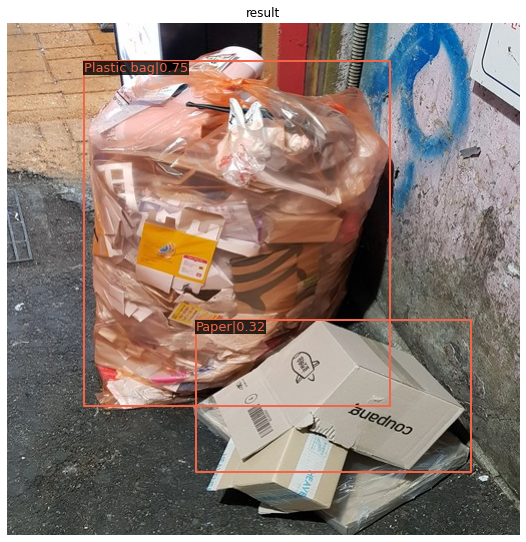

In [20]:
# show the results
show_result_pyplot(model_for_img, img_path, result)